# 18bce129 ( naik kush )
# div B
# sem 4

## dependencies
### tessract engine
### pandas
### nltk
### sklearn
### openCV


# Q1
## in the following code we will prepare our dataset
### tesseract is used for extracting text from image
### here , i have used nltk for removing stopowrds, lematization etc

In [100]:
import os
import pandas as pd
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()
valid_image_extensions = ["jpg", "jpeg"]
temp =[]
category = ['entertainment','trasportation','shopping','miscellaneous','homeUtility','grocery','investment']
stop_words=set(stopwords.words("english"))


# go category by category
for j in category:
    
    # load all image files with permited extentions
    for i in os.listdir(j+'/'):

        # read img and scaling it for better extrsction of data
        if i.split('.')[1] in valid_image_extensions:
            img = cv2.imread(j+'/'+i,1)
            img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
            result = pytesseract.image_to_string(img)
            
         
        if result:
            result = str(result)
            
            # tokenizing words
            tokenized_word = word_tokenize(result)

            # removing stop words
            filtered_sent=[]
            for w in tokenized_word:
                if w not in stop_words:
                    filtered_sent.append(w)

            # lematizing each word
            stemmed_words=[]
            for w in filtered_sent:
                stemmed_words.append(lem.lemmatize(w,"v"))

        # join all word again after preprocessing
        result = ' '.join(stemmed_words)  
        temp.append([result,j])

# dump all data preprocessed into a pandas dataFrame
df = pd.DataFrame(temp,columns = ['text','category'])
df

,text,category
0,"CHLOE81 81 Ludlow St New York , NY 10002 Tel 2...",entertainment
1,eee eet MITASU JAPANESE RESTAURANT SDN BHD B-0...,entertainment
2,eee eet MITASU JAPANESE RESTAURANT SDN BHD B-0...,entertainment
3,Collector ’ Chojce Restaurant 2\ ) Cypress Ave...,entertainment
4,“ Bea BOWL TERI YAK I O GARFIELD AVE. ee GATE ...,entertainment
...,...,...
95,This negotiable document © S B | STATE BANK OF...,investment
96,e-TDR/e-STDR ( Fixed Deposit ) Open new A/c Ma...,investment
97,e-TDR/e-STDR ( Fixed Deposit ) Open new A/c Ma...,investment
98,e-TDR/e-STDR ( Fixed Deposit ) Open new A/c Ma...,investment


# Q1 preparing ml model for categorization of bills

In [46]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# creating pipeline for our model
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

# fit our dataframe into the model : text as feature 
text_clf.fit(df['text'],df['category'])

#dividing test and train dataset
training_set, validation_set = train_test_split(df, test_size = 0.2, random_state = 226)


ans = text_clf.predict(validation_set['text'])


#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ans, validation_set['category'])

#give accuracy 
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements


print("accuracy of model : ",accuracy(cm))


# Saving model for future use
from sklearn.externals import joblib 
joblib.dump(text_clf,'model.pkl')

accuracy of model :  0.9411764705882353


['model.pkl']

# Q1 , Q2
## here you need to give directory name where bills are and below code snippet will find its category, total price, dateOfBilling etc... and save it to respective category's csv files

In [82]:
from sklearn.externals import joblib 
import csv
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
stop_words=set(stopwords.words("english"))
lem = WordNetLemmatizer()


# function to extract price from reciept text
# here , i am finding key words such as total,amount,rate from text and getting price next to it
def get_price(result):
    total = 0
    flag = 0
    for i in str(result).split('\n'):
        flag=0
        i=i.lower()
        if ("total" in i or 'amount' in i or 'ammt' in i or 'rate' in i)and "subtotal" not in i:
            flag=1
        for j in i.split(' '):
            j=j.strip()
            f=0
            for k in j.split('.'):
                k=k.strip()
                if len(k)>1 and not(k[0].isdigit()):
                    k=k[1:]
                if(',' in k):
                    k=''.join(k.split(','))

                if(k.strip().isdigit() and len(k)<=6 and flag and k[0]!='0'):
                        total = max(total,int(k))
                        f=1
                        break
            if f:
                break
    if total != 0:
        return total


#to get date i have used regex which find following kind of dates
# dd-mm-yyyy
# dd/mm/yyyy
# dd mm yyyy
# dd mm yy
# dd-mm-yy
# dd/mm/yy
# dd-mon-yyyy
# dd/mon/yyyy
# dd mon yyyy
def get_date(result):
    l= re.findall("[0-9]{2}[\s/-][0-9]{2}[\s/-][0-9]{2,5}",result)
    if len(l)>0:
        return l[0]
    l= re.findall("[0-9]{2}[\s/-][a-zA-Z]{3}[\s/-][0-9]{2,5}",result)
    if len(l)>0:
        return l[0]
    
    
# here i asuming that billing firm name should be in the first line in reciept
def get_company_name(result):
    return result.split('\n')[0]

#getting tax information if any by regex and finding % in reciept
def get_tax(result):
    ans=0
    l = re.findall('[\.0-9]+[\s]?[%]',result)
    
    #extracting rate from all regex
    for i in l:
        if len(i)>1 and( i[1].isdigit() or i[1]=='.') :
            ans+=float(i.strip()[0:2].strip())
        else:
            ans+=float(i.strip()[0:1].strip())
    return ans

valid_image_extensions = ["jpg", "jpeg" ,"png"]
print("Enter the path of directory having bills : ")
j = input()

#loading all files from given directory with valid_image_extentions
for i in os.listdir(j+'/'):

        # read img and scaling it and also making gray scale for better extrsction of data
        if i.split('.')[1] in valid_image_extensions:
            img = cv2.imread(j+'/'+i,1)
            img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
            result = pytesseract.image_to_string(img)
        
        if result:
            result = str(result)
            
            #   getting attributes
            price = get_price(result)
            date = get_date(result)
            name = get_company_name(result)
            tax = get_tax(result)
            #tokenizing words
            tokenized_word = word_tokenize(result)

            # remove stop words
            filtered_sent=[]
            for w in tokenized_word:
                if w not in stop_words:
                    filtered_sent.append(w)
            # getting lematized text
            stemmed_words=[]
            for w in filtered_sent:
                stemmed_words.append(lem.lemmatize(w,"v"))
                
            # loading model and predict the type of bill
            model = joblib.load('model.pkl')
            category = model.predict([' '.join(stemmed_words)])
            
            #writing csv file 
            with open(category[0]+'.csv','a') as csvfile:
                csvwriter = csv.writer(csvfile)  
                csvwriter.writerow([name,date,tax,price,category[0]])

Enter the path of directory having bills : 
sample


# Q3 ploting bar chart and pie chart 

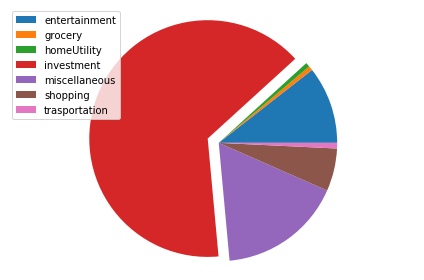

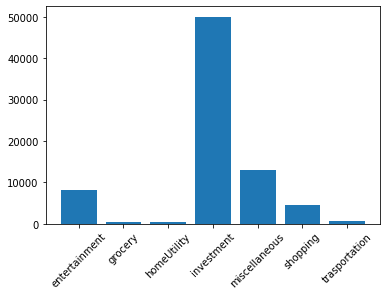

In [98]:
import pandas as pd
from matplotlib import pyplot as plt
category = ['entertainment','trasportation','shopping','miscellaneous','homeUtility','grocery','investment']
df = pd.DataFrame(columns = ['name','billDate','tax','price','category'])
c=0

# Combning all scv files into one dataframe
for i in category:
    temp = pd.read_csv(i+'.csv',parse_dates = ['billDate'])
    temp['price'].interpolate()
#     print(temp)
    for j in range(len(temp)):
        df.loc[c]=temp.loc[j]
        c+=1
        
# group by to get categories data categorywise
g=df.groupby(['category'])
category = []
expence = []
# getting expence of each category
c=0
for i,j in g:
    category.append(i)
    expence.append(j.price.sum())

explode = [0,0,0,0,0,0,0]
explode[3]+=.1
# plotting pie char according to data 
patches,texts = plt.pie(expence,explode)
plt.axis('equal')
plt.legend(patches,category,loc='best')
plt.tight_layout()
plt.show()

# also showing bar plot for better understading
plt.bar(category,expence)
plt.xticks(rotation=45)
plt.show()

# Q3,Q4 following codes give overview of users expences and gives relative suggetions

In [84]:
print("you have following expences in follwing catregories :-")
df[['category','price']].groupby(['category']).sum().sort_values(by=['price'],ascending=False)

you have following expences in follwing catregories :-


,price
category,
investment,50000.0
miscellaneous,13098.0
entertainment,8162.0
shopping,4504.0
trasportation,592.0
grocery,468.0
homeUtility,460.0


# high expence categories

In [85]:
print(">>> you should reduce your expence in following category :-")
df[['category','price']].groupby(['category']).sum().sort_values(by=['price'],ascending=False).head(2)

>>> you should reduce your expence in following category :-


,price
category,
investment,50000.0
miscellaneous,13098.0


# low expence categories

In [86]:
print(">>> you may spend more in following category :-")
df[['category','price']].groupby(['category']).sum().sort_values(by=['price']).head(2)

>>> you may spend more in following category :-


,price
category,
homeUtility,460.0
grocery,468.0


# mean expence

In [87]:
print("your mean expence on each category is : ")
df[['category','price']].groupby(['category']).sum().mean()

your mean expence on each category is : 


price    11040.571429
dtype: float64

# TOTAL expence 

In [89]:
print("your total expence till now is :")
df[['category','price']].groupby(['category']).sum().sum()

your total expence till now is :


price    77284.0
dtype: float64